In [1]:
import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pathlib import Path
from gmm.base_models.general_ou import OU
from gmm.models.ou_gmm import OU_GMM
sys.executable

'C:\\Users\\Os\\AppData\\Local\\Programs\\Python\\Python310\\python.exe'

In [2]:
data_path = Path('gmm/datas/global_equity_ticker.csv')
df = pd.read_csv(data_path)
df.head

<bound method NDFrame.head of                  ID        DATE CURRENCY   PX_LAST
0      MEXBOL Index  2021-01-25      MXN  45126.52
1      MEXBOL Index  2021-01-26      MXN  45053.56
2      MEXBOL Index  2021-01-27      MXN  44262.01
3      MEXBOL Index  2021-01-28      MXN  44280.73
4      MEXBOL Index  2021-01-29      MXN  42985.73
...             ...         ...      ...       ...
36535     SMI Index  2026-01-21      CHF  13156.81
36536     SMI Index  2026-01-22      CHF  13228.40
36537     SMI Index  2026-01-23      CHF  13147.13
36538     SMI Index  2026-01-24      CHF  13147.13
36539     SMI Index  2026-01-25      CHF  13147.13

[36540 rows x 4 columns]>

In [3]:
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values(["ID", "DATE"])
print(df)

               ID       DATE CURRENCY   PX_LAST
25578  AS51 Index 2021-01-25      AUD  6824.713
25579  AS51 Index 2021-01-26      AUD  6824.713
25580  AS51 Index 2021-01-27      AUD  6780.566
25581  AS51 Index 2021-01-28      AUD  6649.694
25582  AS51 Index 2021-01-29      AUD  6607.357
...           ...        ...      ...       ...
12784   WLS Index 2026-01-21      USD  2331.660
12785   WLS Index 2026-01-22      USD  2348.540
12786   WLS Index 2026-01-23      USD  2350.560
12787   WLS Index 2026-01-24      USD  2350.560
12788   WLS Index 2026-01-25      USD  2350.560

[36540 rows x 4 columns]


In [4]:
us_id   = "SPX Index"
indo_id = "JCI Index"
us = (df[df["ID"] == us_id][["DATE", "PX_LAST"]].rename(columns={"PX_LAST": "PX_US"}))
indo = (df[df["ID"] == indo_id][["DATE", "PX_LAST"]].rename(columns={"PX_LAST": "PX_ID"}))
print(us)
print(indo)

           DATE    PX_US
1827 2021-01-25  3855.36
1828 2021-01-26  3849.62
1829 2021-01-27  3750.77
1830 2021-01-28  3787.38
1831 2021-01-29  3714.24
...         ...      ...
3649 2026-01-21  6875.62
3650 2026-01-22  6913.35
3651 2026-01-23  6915.61
3652 2026-01-24  6915.61
3653 2026-01-25  6915.61

[1827 rows x 2 columns]
            DATE     PX_ID
14616 2021-01-25  6258.572
14617 2021-01-26  6140.171
14618 2021-01-27  6109.168
14619 2021-01-28  5979.387
14620 2021-01-29  5862.352
...          ...       ...
16438 2026-01-21  9010.330
16439 2026-01-22  8992.183
16440 2026-01-23  8951.010
16441 2026-01-24  8951.010
16442 2026-01-25  8951.010

[1827 rows x 2 columns]


In [5]:
data = (us.merge(indo, on="DATE", how="inner").dropna().sort_values("DATE"))
data["log_us"] = np.log(data["PX_US"])
data["log_id"] = np.log(data["PX_ID"])
print(data)

           DATE    PX_US     PX_ID    log_us    log_id
0    2021-01-25  3855.36  6258.572  8.257220  8.741707
1    2021-01-26  3849.62  6140.171  8.255730  8.722608
2    2021-01-27  3750.77  6109.168  8.229716  8.717546
3    2021-01-28  3787.38  5979.387  8.239430  8.696073
4    2021-01-29  3714.24  5862.352  8.219929  8.676306
...         ...      ...       ...       ...       ...
1822 2026-01-21  6875.62  9010.330  8.835737  9.106127
1823 2026-01-22  6913.35  8992.183  8.841210  9.104111
1824 2026-01-23  6915.61  8951.010  8.841536  9.099522
1825 2026-01-24  6915.61  8951.010  8.841536  9.099522
1826 2026-01-25  6915.61  8951.010  8.841536  9.099522

[1827 rows x 5 columns]


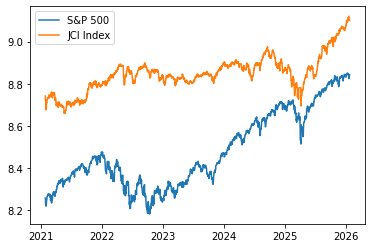

In [6]:
plt.plot(data["DATE"], data["log_us"], label='S&P 500')
plt.plot(data["DATE"], data["log_id"], label='JCI Index')
plt.legend()

In [7]:
X = sm.add_constant(data["log_us"])
beta_hat = sm.OLS(data["log_id"], X).fit().params[1]
print(f"estimated beta (ID vs US): {beta_hat:.4f}")

estimated beta (ID vs US): 0.3065


In [8]:
spread = data["log_id"] - beta_hat * data["log_us"]
X = spread.values
print(X)

[6.21050765 6.19186493 6.19477714 ... 6.38920328 6.38920328 6.38920328]


In [12]:
dt = 1 / 252
ou_gmm = OU_GMM(dt=dt, verbose=True)
ou_gmm.fit(X)
kappa, theta, sigma = ou_gmm.params_


OU GMM calibration complete
kappa = -0.003039
theta = 0.040173
sigma = 0.100021
J-stat = 1.315163e-09


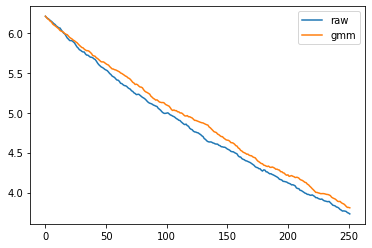

In [17]:
ou_raw = OU(X0=X[0], kappa=0.5, theta=0.0, sigma=0.1, dt=1/252)
ou_gmm = OU(X0=X[0], kappa=kappa, theta=theta, sigma=sigma, dt=1/252)
ou_raw_paths = ou_raw.simulate(T=252)
ou_gmm_paths = ou_raw.simulate(T=252)
plt.plot(ou_raw_paths, label='raw')
plt.plot(ou_gmm_paths, label='gmm')
plt.legend()
plt.show()

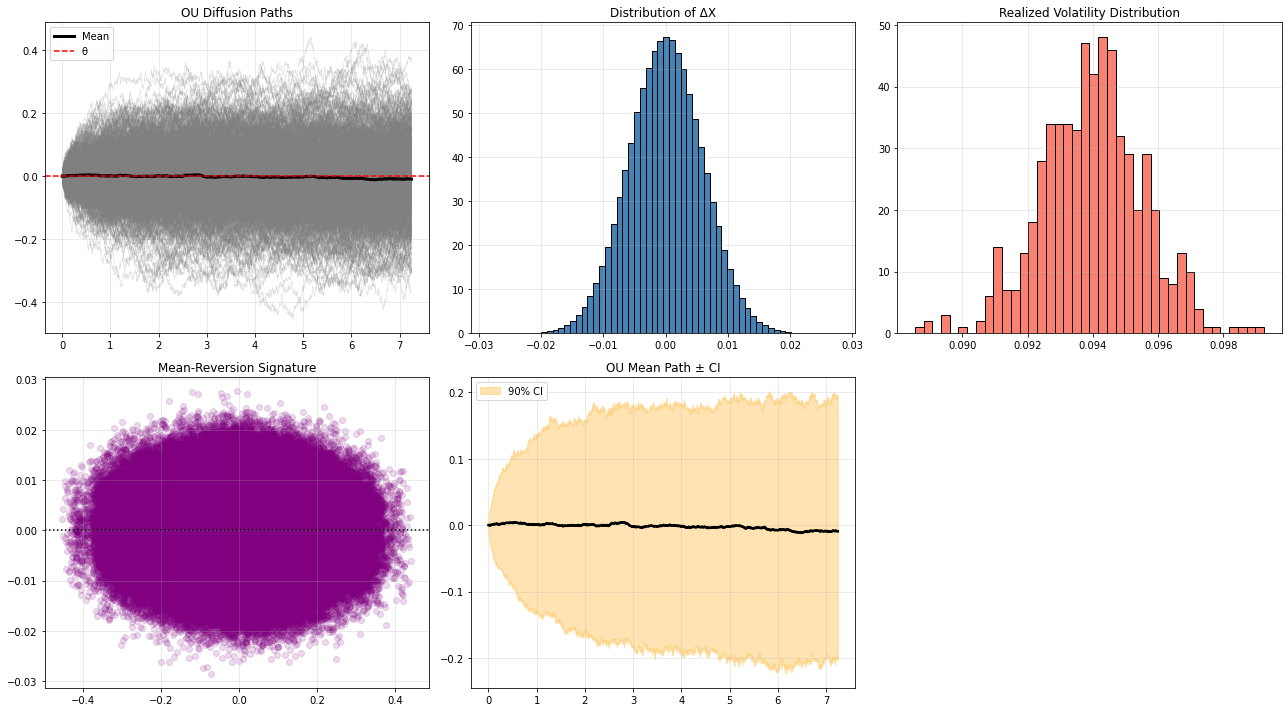

In [ ]:
ou_usppa=results["WLS Index"]["kappa"], theta=0, sigma=results["WLS Index"]["sigma"])
ou_us.plot_diagnostics(T=len(spread),paths=600,seed=42) 